# Impor Library

In [1]:
import itertools
import joblib
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set();

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector as selector
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix
from dython.nominal import associations

pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_colwidth", 1000)

# Persiapkan Data

In [2]:
csv_filename = "loan_data_2007_2014.csv"
feather_filename = "loan_data_2007_2014.feather"

## Membaca Data
Baca data berformat `.csv` setelah itu simpan ke dalam bentuk `.feather`

In [3]:
if not os.path.exists(feather_filename):
    # Baca melalui csv
    df = pd.read_csv("loan_data_2007_2014.csv")

    # Ubah ke feather
    df.to_feather("loan_data_2007_2014.feather")

## Pindah ke Ekstensi Feather
Perpindahan ekstensi dimaksudkan untuk mempercepat proses membaca file. Dibutuhkan waktu sekitar 17 detik untuk membaca file `.csv` sedangkan untuk file `.feather` hanya dibutuhkan waktu sekitar 3 detik

In [4]:
raw_df = pd.read_feather(feather_filename)

## Melihat Sampel Data
Kita perlu mengetahui seperti apa nilai yang terdapat pada semua kolom

In [5]:
raw_df.head()

,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,B,B2,None,10+ years,RENT,24000.0,Verified,Dec-11,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail.action?loan_id=1077501,Borrower added on 12/22/11 > I need to upgrade my business technologies.<br>,credit_card,Computer,860xx,AZ,27.65,0.0,Jan-85,1.0,NaN,NaN,3.0,0.0,13648,83.7,9.0,f,0.0,0.0,5861.071414,5831.78,5000.00,861.07,0.00,0.00,0.00,Jan-15,171.62,None,Jan-16,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,Dec-11,Charged Off,n,https://www.lendingclub.com/browse/loanDetail.action?loan_id=1077430,Borrower added on 12/22/11 > I plan to use this money to finance the motorcycle i am looking at. I plan to have it paid off as soon as possible/when i sell my old bike. I only need this money because the deal im looking at is to good to pass up.<br><br> Borrower added on 12/22/11 > I plan to use this money to finance the motorcycle i am looking at. I plan to have it paid off as soon as possible/when i sell my old bike.I only need this money because the deal im looking at is to good to pass up. I have finished college with an associates degree in business and its takingmeplaces<br>,car,bike,309xx,GA,1.00,0.0,Apr-99,5.0,NaN,NaN,3.0,0.0,1687,9.4,4.0,f,0.0,0.0,1008.710000,1008.71,456.46,435.17,0.00,117.08,1.11,Apr-13,119.66,None,Sep-13,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,C,C5,None,10+ years,RENT,12252.0,Not Verified,Dec-11,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail.action?loan_id=1077175,None,small_business,real estate business,606xx,IL,8.72,0.0,Nov-01,2.0,NaN,NaN,2.0,0.0,2956,98.5,10.0,f,0.0,0.0,3003.653644,3003.65,2400.00,603.65,0.00,0.00,0.00,Jun-14,649.91,None,Jan-16,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,C,C1,AIR RESOURCES BOARD,10+ years,RENT,49200.0,Source Verified,Dec-11,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail.action?loan_id=1076863,"Borrower added on 12/21/11 > to pay for property tax (borrow from friend, need to pay back) & central A/C need to be replace. I'm very sorry to let my loan expired last time.<br>",other,personel,917xx,CA,20.00,0.0,Feb-96,1.0,35.0,NaN,10.0,0.0,5598,21.0,37.0,f,0.0,0.0,12226.302210,12226.30,10000.00,2209.33,16.97,0.00,0.00,Jan-15,357.48,None,Jan-15,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,B,B5,University Medical Group,1 year,RENT,80000.0,Source Verified,Dec-11,Current,n,https://www.lendingclub.com/browse/loanDetail.action?loan_id=1075358,"Borrower added on 12/21/11 > I plan on combining three large interest bills togethe

# Deskripsi Data
Berikut info mengenai data:

In [6]:
data_dict = pd.read_excel("LCDataDictionary.xlsx", sheet_name="LoanStats")

c:\Users\garci\AppData\Local\Programs\Python\Python37\lib\site-packages\openpyxl\worksheet\_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


## Definisi

In [7]:
data_dict[["Feature", "Description"]]

,Feature,Description
0,addr_state,The state provided by the borrower in the loan application
1,annual_inc,The self-reported annual income provided by the borrower during registration.
2,annual_inc_joint,The combined self-reported annual income provided by the co-borrowers during registration
3,application_type,Indicates whether the loan is an individual application or a joint application with two co-borrowers
4,collection_recovery_fee,post charge off collection fee
5,collections_12_mths_ex_med,Number of collections in 12 months excluding medical collections
6,delinq_2yrs,The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years
7,desc,Loan description provided by the borrower
8,dti,"A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income."
9,dti_joint,"A ratio calculated using the co-borrowers' total monthly payments on the total debt obligations, excluding mortgages and the requested LC loan, divided by the co-borrowers' combined self-reported monthly income"


## Rincian DataFrame

In [8]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466285 entries, 0 to 466284
Data columns (total 75 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Unnamed: 0                   466285 non-null  int64  
 1   id                           466285 non-null  int64  
 2   member_id                    466285 non-null  int64  
 3   loan_amnt                    466285 non-null  int64  
 4   funded_amnt                  466285 non-null  int64  
 5   funded_amnt_inv              466285 non-null  float64
 6   term                         466285 non-null  object 
 7   int_rate                     466285 non-null  float64
 8   installment                  466285 non-null  float64
 9   grade                        466285 non-null  object 
 10  sub_grade                    466285 non-null  object 
 11  emp_title                    438697 non-null  object 
 12  emp_length                   445277 non-null  object 
 13 

# EDA

In [9]:
title_font = dict(size=20, weight="bold")

def plot_count(df, y, title, **sns_kwargs):
    value_counts = df[y].value_counts()
    percentage = value_counts / value_counts.sum()
    percentage = percentage.apply("{:.2%}".format)

    plt.figure(figsize=(14, 10))
    plt.title(title, fontdict=title_font)
    sns.countplot(data=df, y=y, order=value_counts.index, **sns_kwargs)
    plt.ylabel("")
    plt.show()

    print(percentage)


def plot_distribution(df, x, title, **sns_kwargs):
    plt.figure(figsize=(14, 10))
    plt.title(title, fontdict=title_font)
    sns.histplot(data=df, x=x, kde=True, **sns_kwargs)
    plt.ylabel("")
    plt.show()


def plot_boxplot(df, x, y, title, **sns_kwargs):
    plt.figure(figsize=(14, 10))
    plt.title(title, fontdict=title_font)
    sns.boxplot(data=df, x=x, y=y, **sns_kwargs)
    plt.ylabel("")
    plt.show()

## Status Pinjaman
Sebagian besar pinjaman berada dalam status "sedang berjalan". Pada tingkat keberhasilan, pinjaman yang berhasil dibayarkan kembali memiliki rasio yang lebih tinggi ketimbang pinjaman yang terlambat.

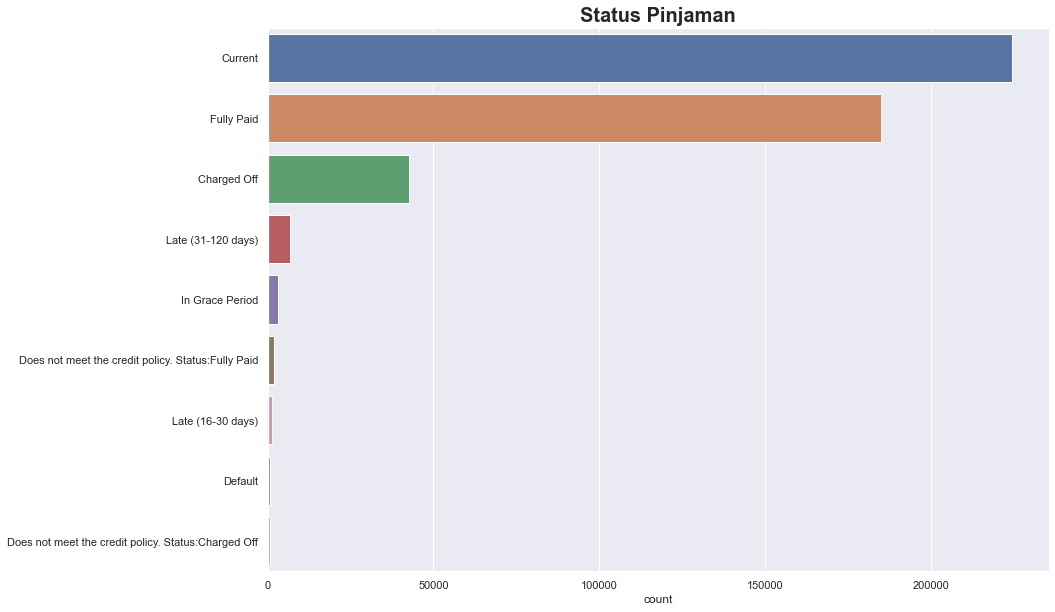

Current                                                48.09%
Fully Paid                                             39.62%
Charged Off                                             9.11%
Late (31-120 days)                                      1.48%
In Grace Period                                         0.67%
Does not meet the credit policy. Status:Fully Paid      0.43%
Late (16-30 days)                                       0.26%
Default                                                 0.18%
Does not meet the credit policy. Status:Charged Off     0.16%
Name: loan_status, dtype: object


In [10]:
plot_count(raw_df, title="Status Pinjaman",  y="loan_status")

## Menentukan Status Pinjaman
Tujuan kita disini adalah menentukan pinjaman mana yang berkemungkinan untuk gagal bayar, sehingga kategori yang bisa kita ambil adalah diantara yang berhasil dan yang gagal. Oleh karena itu kita hanya akan mengambil 2 kategori yaitu:
- Disetujui, terdiri dari: Fully Paid
- Ditolak, terdiri dari: Charged Off, Default, dan Does not meet the credit policy

Kita tidak bisa menggunakan `current` karena pinjaman tersebut masih berlangsung, begitu pula dengan `late` dan `in_grace_period`.

In [11]:
# Tentukan kategori yang akan digunakan
approved_cat = ["Fully Paid"]
dissaproved_cat = [
    "Charged Off",
    "Default",
    "Does not meet the credit policy. Status:Fully Paid",
    "Does not meet the credit policy. Status:Charged Off"
]

In [12]:
# Ganti dengan label baru
def label_loan_status(value):
    if value in approved_cat:
        return 1
    return 0

label_loan_status("Fully Paid")

1

In [13]:
# Saring dan terapkan fungsi
inter_df = raw_df[raw_df["loan_status"].isin(approved_cat + dissaproved_cat)].copy()
inter_df["loan_status"] = inter_df["loan_status"].apply(label_loan_status)

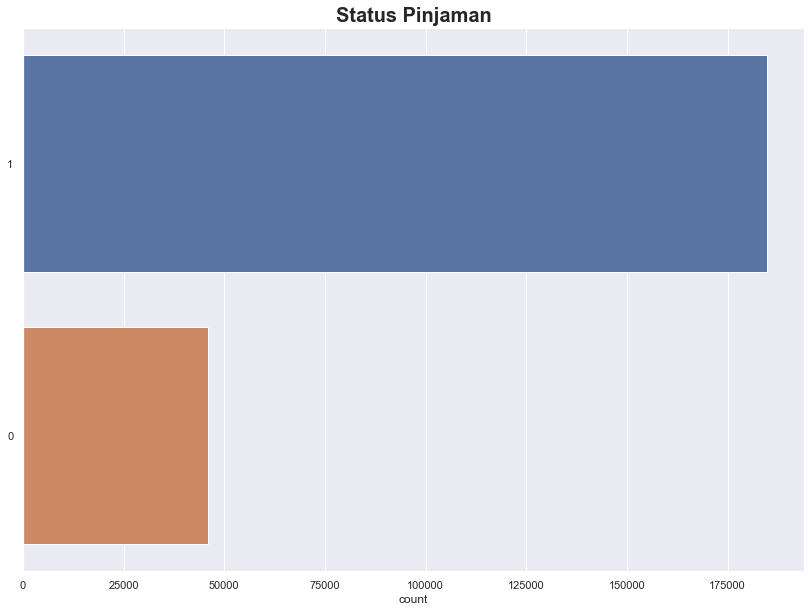

1    80.04%
0    19.96%
Name: loan_status, dtype: object


In [14]:
plot_count(inter_df, y="loan_status", title="Status Pinjaman")

## Korelasi antar Variabel

In [15]:
# Hitung korelasi tiap variabel
correlations = (inter_df.select_dtypes(exclude=object)
                         .corr()
                         .dropna(how="all", axis=0)
                         .dropna(how="all", axis=1)
)

In [16]:
correlations["loan_status"].abs().sort_values(ascending=False)

loan_status                    1.000000
total_rec_prncp                0.460338
recoveries                     0.445422
last_pymnt_amnt                0.384781
total_pymnt_inv                0.358588
total_pymnt                    0.355349
collection_recovery_fee        0.300094
int_rate                       0.241059
total_rec_late_fee             0.152231
inq_last_6mths                 0.116393
dti                            0.107257
out_prncp                      0.099816
out_prncp_inv                  0.099814
revol_util                     0.089180
tot_cur_bal                    0.076230
mths_since_last_record         0.062190
annual_inc                     0.061623
total_rev_hi_lim               0.052931
loan_amnt                      0.049253
funded_amnt                    0.048790
funded_amnt_inv                0.039854
installment                    0.033419
total_rec_int                  0.032997
total_acc                      0.030680
mths_since_last_delinq         0.029299


In [17]:
# Saring korelasi antara vmin - vmax
vmin, vmax = 0.1, 0.99

unstack_corr = correlations.unstack()
pos_corr = (unstack_corr > vmin) & (unstack_corr < vmax)
neg_corr = (unstack_corr > -vmax) & (unstack_corr < -vmin)
high_corr = unstack_corr[pos_corr | neg_corr]

trimmed_corr = high_corr.sort_values(ascending=False).unstack()

In [18]:
# Buat mask untuk membentuk matriks segitiga bawah
mask = np.zeros_like(trimmed_corr)
mask[np.triu_indices_from(mask)] = True

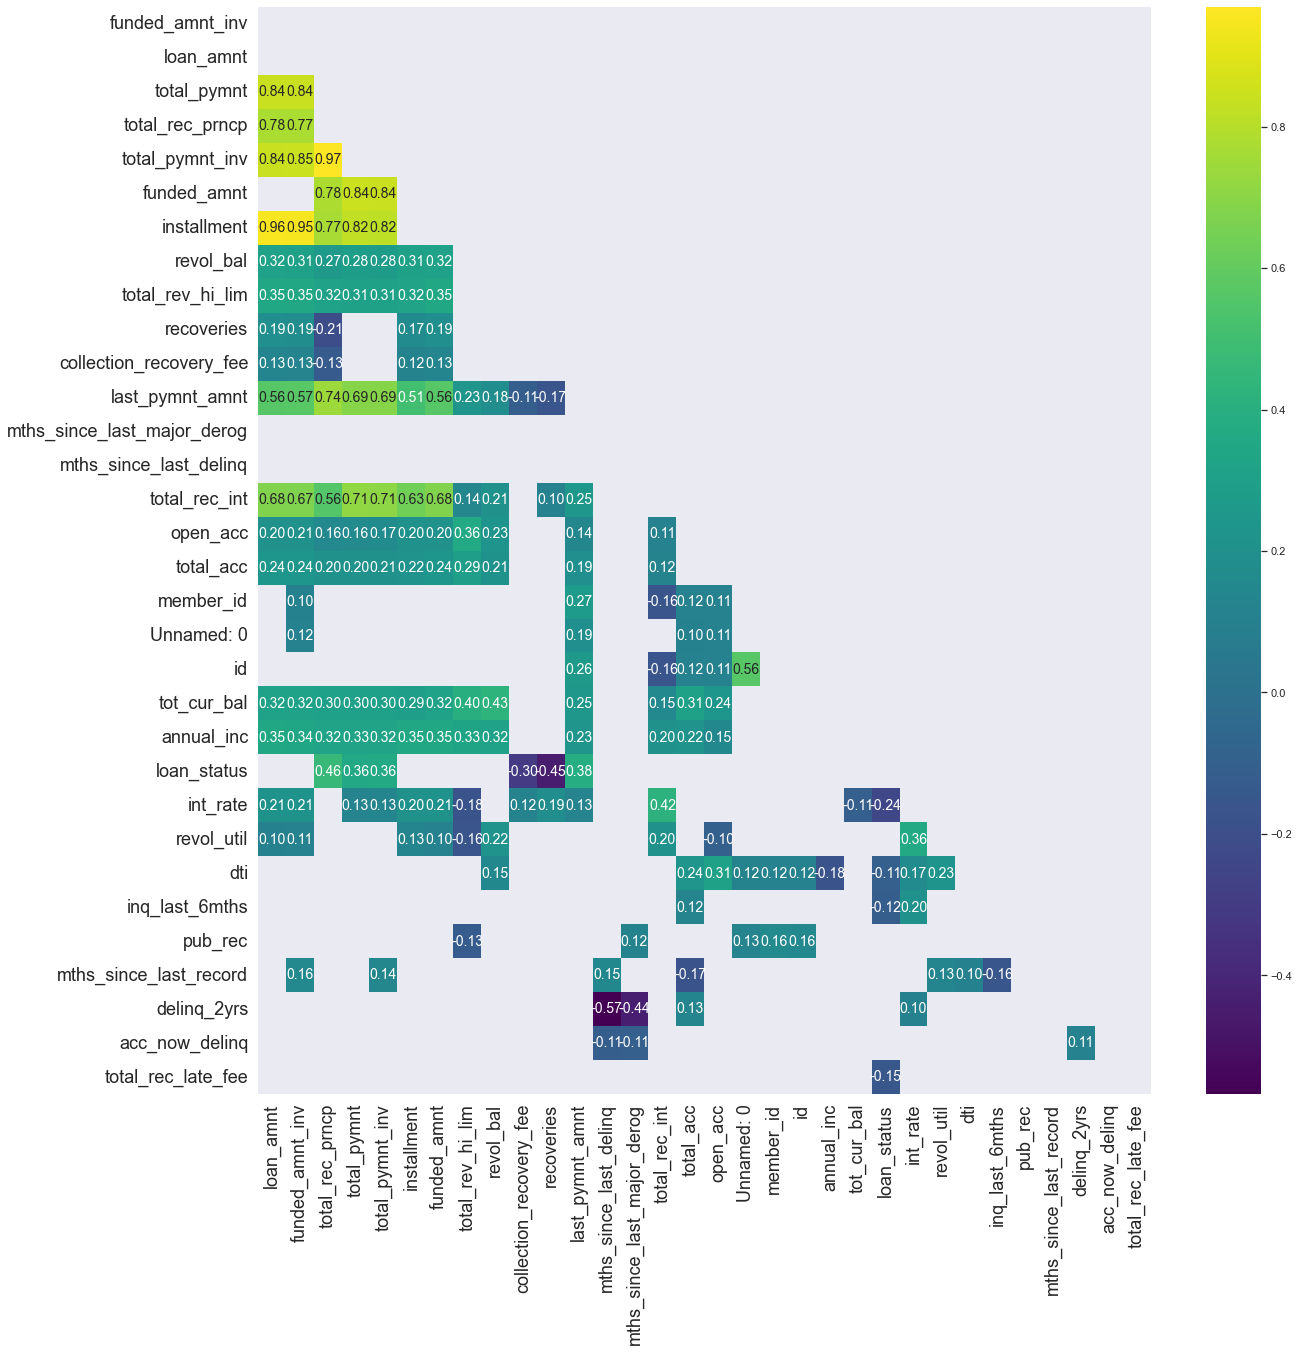

In [19]:
# Tampilkan heatmap
plt.figure(figsize=(20, 20))
plot = sns.heatmap(
    trimmed_corr, 
    annot=True, 
    mask=mask,
    fmt=".2f", 
    cmap="viridis", 
    annot_kws={"size": 14})

plot.set_xticklabels(plot.get_xticklabels(), size=18)
plot.set_yticklabels(plot.get_yticklabels(), size=18)
plt.show()

Dari heatmap diatas terdapat beberapa variabel yang memiliki pengaruh terhadap status pinjaman, diantaranya:

In [20]:
affect_loan = high_corr.loc["loan_status"].abs().sort_values(ascending=False)
affect_loan

total_rec_prncp            0.460338
recoveries                 0.445422
last_pymnt_amnt            0.384781
total_pymnt_inv            0.358588
total_pymnt                0.355349
collection_recovery_fee    0.300094
int_rate                   0.241059
total_rec_late_fee         0.152231
inq_last_6mths             0.116393
dti                        0.107257
dtype: float64

Sedangkan fitur yang saling berkorelasi dengan yang sebelumnya perlu kita identifikasi. Kita menggunakan nilai batas 0.9 untuk mencari fitur yang saling berkorelasi kuat.

In [21]:
threshold = 0.9
affect_collision = (high_corr.abs()
                             .loc[high_corr > threshold]
                             .loc[affect_loan.index, affect_loan.index]
                             .sort_values(ascending=False)
)
affect_collision

total_rec_prncp  total_pymnt        0.975030
total_pymnt      total_rec_prncp    0.975030
total_rec_prncp  total_pymnt_inv    0.969473
total_pymnt_inv  total_rec_prncp    0.969473
dtype: float64

Berdasarkan besar pengaruhnya terhadap status pinjaman, fitur yang saling berkorelasi akan dipilih berdasarkan yang paling berpengaruh.

In [22]:
left_index = affect_collision.index.get_level_values(0)
right_index = affect_collision.index.get_level_values(1)

def remove_collide_index(left_index, right_index):
    include, exclude = [], []

    for left, right in zip(left_index, right_index):
        if left not in include and left not in exclude:
            include.append(left)
        if right not in include and right not in exclude:
            exclude.append(right)
        
    return include, exclude


include_affect_col, exclude_affect_col = remove_collide_index(left_index, right_index)
include_affect_col, exclude_affect_col

(['total_rec_prncp'], ['total_pymnt', 'total_pymnt_inv'])

Fitur numerik berpengaruh yang akan kita gunakan

In [23]:
affect_num_cols = affect_loan[~affect_loan.index.isin(exclude_affect_col)].index.to_list()
affect_num_cols

['total_rec_prncp',
 'recoveries',
 'last_pymnt_amnt',
 'collection_recovery_fee',
 'int_rate',
 'total_rec_late_fee',
 'inq_last_6mths',
 'dti']

## Status Pinjaman dan Besar Pinjaman Pokok yang Sudah Dibayarkan
Principal adalah besar pinjaman pokok yang dipinjamkan kepada debitur. Dengan kata lain merupakan jumlah asli dari uang yang dipinjamkan. Orang yang mengalami gagal bayar kebanyakan belum dapat membayarkan uang pokok pembayaran hingga jatuh tempo, bisa dilihat dari distribusi pembayaran dibawah. Rata-ratanya hampir mencapai 0.


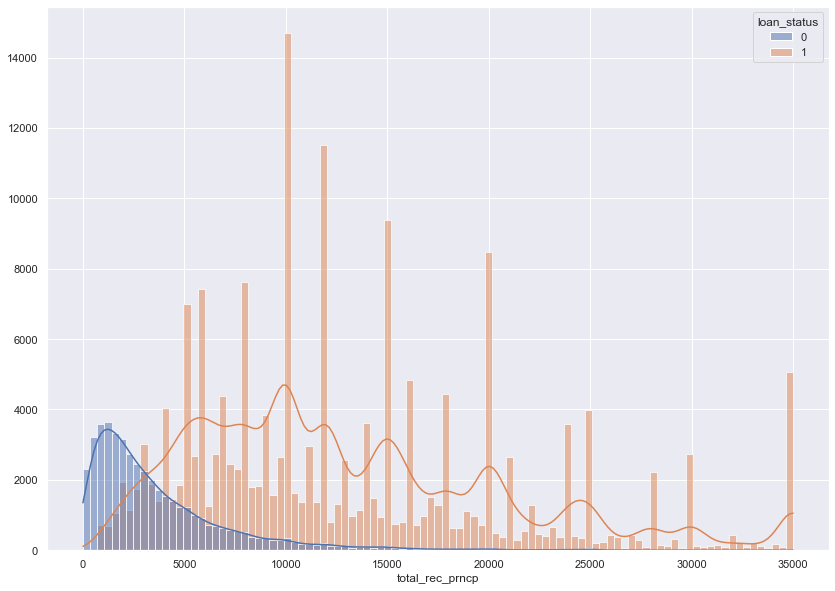

In [24]:
plot_distribution(df=inter_df, x="total_rec_prncp", hue="loan_status", title="")

## Status Pinjaman dan Total Uang yang Tidak Ditagihkan
Charged off recoveries adalah total uang yang tidak bisa dibayarkan kepada perusahaan peminjam karena sudah lewat masa jatuh tempo sehingga perusahaan peminjam bisa melepas hak tagih utang tersebut dengan menjualnya ke perusahaan lain. Dari sini terlihat jelas bahwa orang dengan status pinjaman buruk lah yang paling banyak memiliki charge off recoveries.

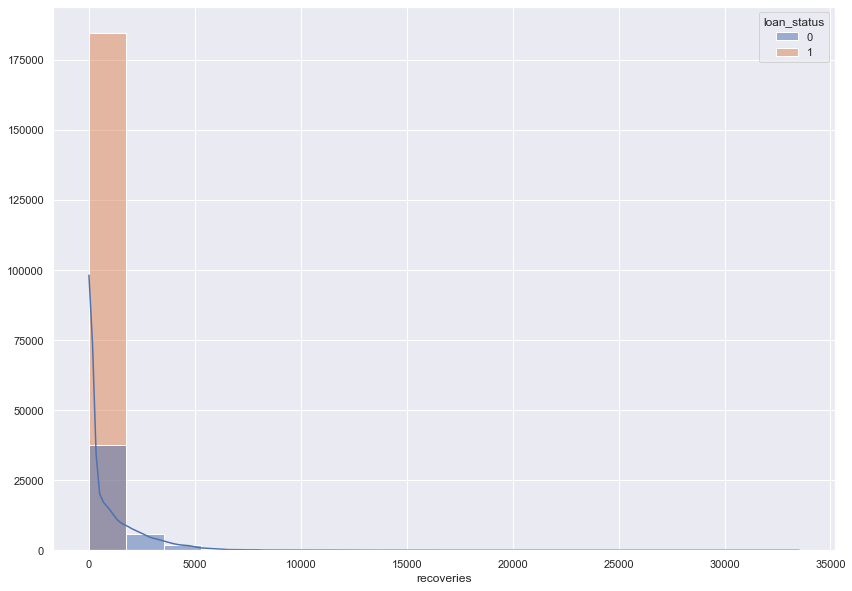

In [25]:
plot_distribution(df=inter_df, x="recoveries", hue="loan_status", title="")

## Status Pinjaman dan Jumlah Pinjaman
Rata-rata jumlah pinjaman terbanyak berada pada status `buruk`.

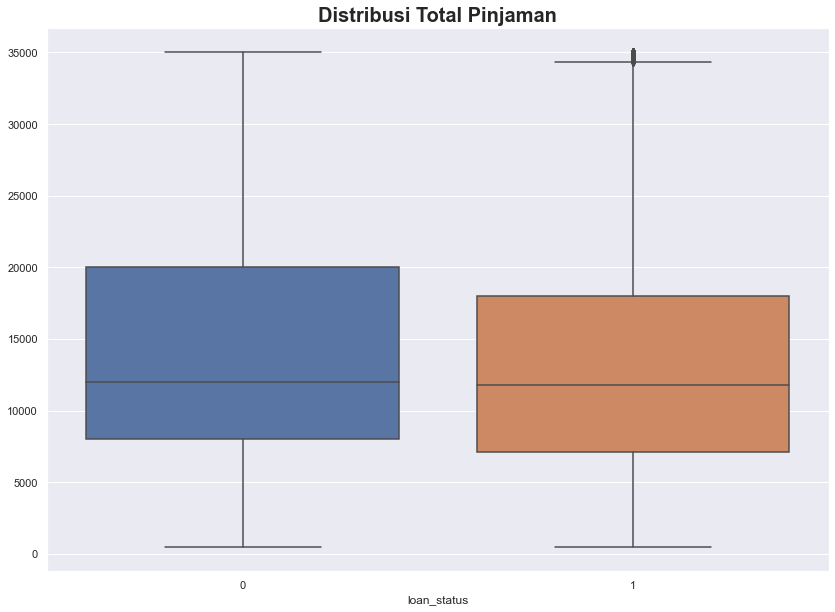

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
0,46056.0,14205.570393,8362.468087,500.0,8000.0,12000.0,20000.0,35000.0
1,184739.0,13214.394226,7949.030252,500.0,7125.0,11800.0,18000.0,35000.0


In [26]:
x, y = "loan_status", "loan_amnt"
plot_boxplot(df=inter_df, x=x, y=y, title="Distribusi Total Pinjaman")
inter_df.groupby(x)[y].describe()

## Status Pinjaman dan Total Pembayaran yang Diterima
Tampak jelas apabila total pembayaran terbanyak berada pada pinjaman yang berstatus `baik`.

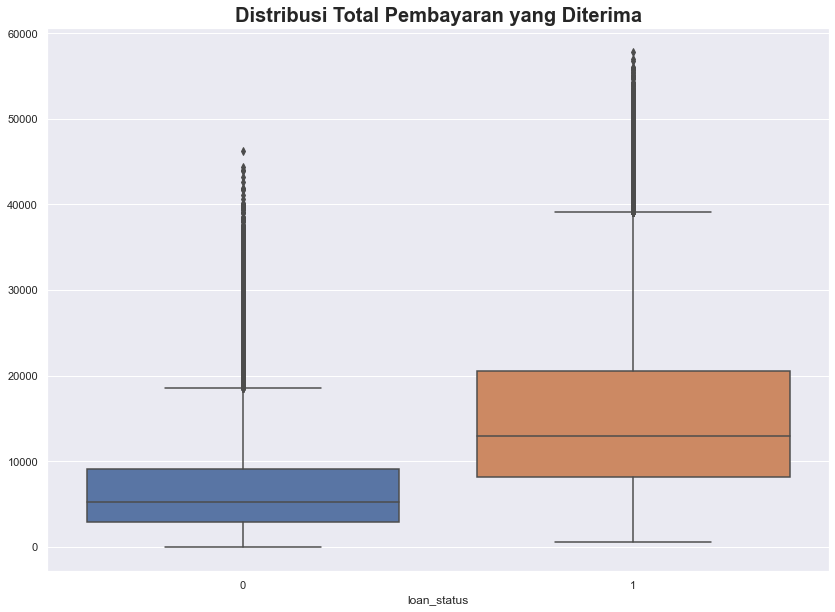

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
0,46056.0,6814.461231,5610.294962,0.00,2829.912500,5260.94000,9120.685,46199.44000
1,184739.0,15209.872007,9459.142043,526.33,8092.460697,12979.34106,20491.905,57777.57987


In [27]:
x, y = "loan_status", "total_pymnt"
plot_boxplot(df=inter_df, x=x, y=y, title="Distribusi Total Pembayaran yang Diterima")
inter_df.groupby(x)[y].describe()

## Tujuan Mengambil Pinjaman
Lebih dari setengah peminjam memiliki tujuan untuk menutup pinjaman sebelumnya. Apabila dilihat dari jenisnya, tujuan untuk konsumsi lebih banyak daripada tujuan untuk bisnis, renovasi dan pendidikan.

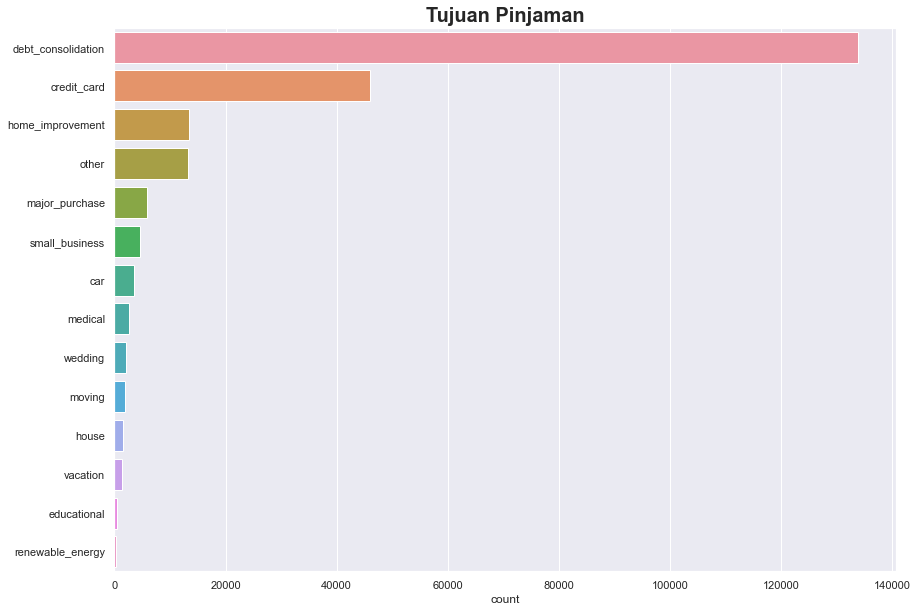

debt_consolidation    58.03%
credit_card           19.95%
home_improvement       5.83%
other                  5.76%
major_purchase         2.54%
small_business         2.02%
car                    1.50%
medical                1.15%
wedding                0.87%
moving                 0.80%
house                  0.65%
vacation               0.62%
educational            0.18%
renewable_energy       0.11%
Name: purpose, dtype: object


In [28]:
plot_count(inter_df, y="purpose", title="Tujuan Pinjaman")

## Negara Asal Peminjam
Peminjam sebagian besar berasal dari negara Kanada.


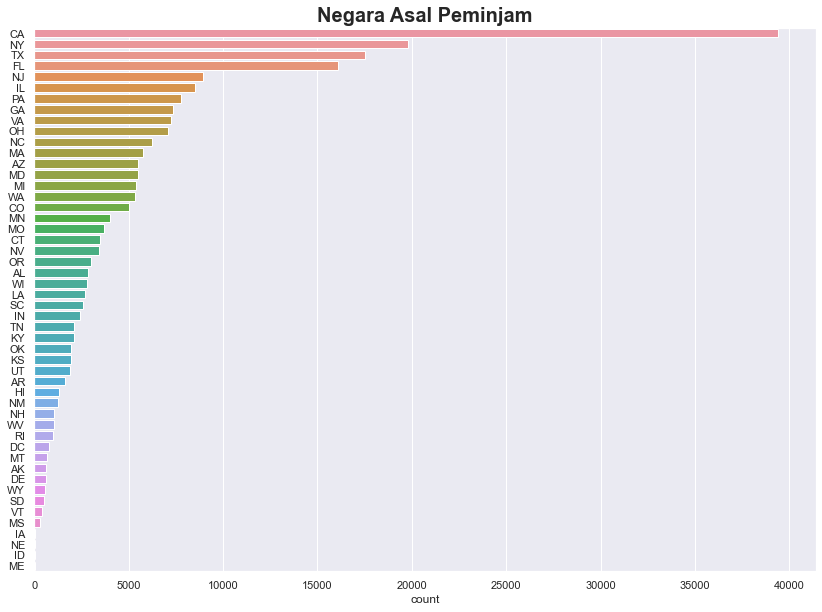

CA    17.08%
NY     8.58%
TX     7.60%
FL     6.96%
NJ     3.87%
IL     3.70%
PA     3.36%
GA     3.17%
VA     3.14%
OH     3.06%
NC     2.69%
MA     2.48%
AZ     2.38%
MD     2.37%
MI     2.33%
WA     2.32%
CO     2.18%
MN     1.73%
MO     1.59%
CT     1.50%
NV     1.49%
OR     1.31%
AL     1.24%
WI     1.21%
LA     1.16%
SC     1.11%
IN     1.04%
TN     0.91%
KY     0.90%
OK     0.84%
KS     0.83%
UT     0.82%
AR     0.70%
HI     0.57%
NM     0.54%
NH     0.46%
WV     0.45%
RI     0.43%
DC     0.34%
MT     0.29%
AK     0.27%
DE     0.26%
WY     0.24%
SD     0.21%
VT     0.17%
MS     0.13%
IA     0.01%
NE     0.01%
ID     0.00%
ME     0.00%
Name: addr_state, dtype: object


In [29]:
plot_count(df=inter_df, y="addr_state", title="Negara Asal Peminjam")

## Tingkat Pinjaman
Pinjaman diberi tingkatan dari huruf abjad A sampai G, semakin mendekati G maka tingkat bunga yang dibayarkan lebih besar.

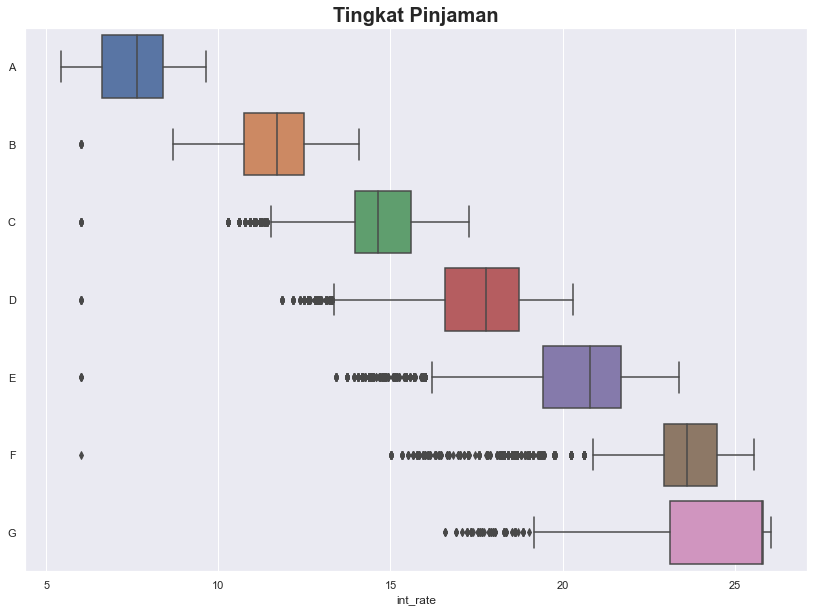

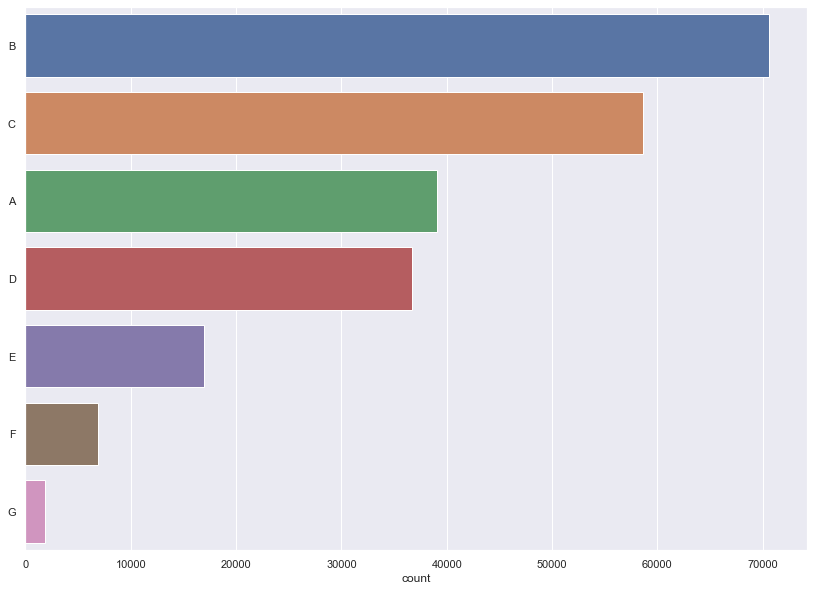

B    30.60%
C    25.40%
A    16.95%
D    15.92%
E     7.34%
F     2.99%
G     0.80%
Name: grade, dtype: object


,count,mean,std,min,25%,50%,75%,max
grade,,,,,,,,
A,39110.0,7.545742,1.003571,5.42,6.62,7.62,8.39,9.63
B,70622.0,11.654616,1.281087,6.00,10.74,11.71,12.49,14.09
C,58626.0,14.767515,1.233598,6.00,13.98,14.64,15.61,17.27
D,36740.0,17.628885,1.484771,6.00,16.59,17.77,18.75,20.31
E,16945.0,20.341001,1.920465,6.00,19.42,20.80,21.70,23.40
F,6896.0,23.137195,2.097052,6.00,22.95,23.63,24.50,25.57
G,1856.0,24.191482,2.509841,16.59,23.13,25.80,25.83,26.06


In [30]:
x, y = "int_rate", "grade"
order = inter_df[y].sort_values().unique()
plot_boxplot(inter_df, x=x, y=y, title="Tingkat Pinjaman", order=order)
plot_count(df=inter_df, y=y, title="")
inter_df.groupby(y)[x].describe()

## Status Kepemilikan Rumah
Sebagian besar peminjam mendelegasikan rumahnya sebagai jaminan pinjaman, sedangkan hanya sedikit dari peminjam yang memiliki rumah sendiri.

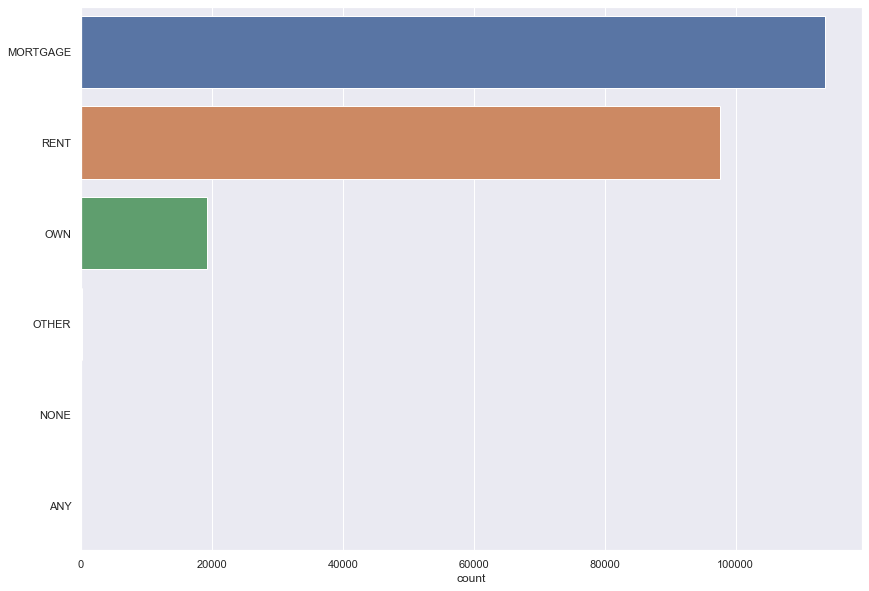

MORTGAGE    49.23%
RENT        42.29%
OWN          8.38%
OTHER        0.08%
NONE         0.02%
ANY          0.00%
Name: home_ownership, dtype: object


In [31]:
y = "home_ownership"
order = inter_df[y].sort_values().unique()
plot_count(df=inter_df, y=y, title="")

# Praproses Data

## Menghilangkan fitur yang tidak terpakai
Setelah melihat info dan deskripsi dari data diatas, terdapat fitur yang tidak perlu kita pakai karena tidak begitu signifikan untuk digunakan sebagai fitur dalam prediksi.

In [32]:
# Informasi rinci mengenai kolom dan baris data
data_stat = pd.DataFrame()
data_stat.index = inter_df.columns
data_stat["unique_value"] = inter_df.nunique()
data_stat["missing_rate"] = inter_df.isna().mean()
data_stat["dtype"] = inter_df.dtypes
data_stat

,unique_value,missing_rate,dtype
Unnamed: 0,230795,0.000000,int64
id,230795,0.000000,int64
member_id,230795,0.000000,int64
loan_amnt,1308,0.000000,int64
funded_amnt,1311,0.000000,int64
funded_amnt_inv,9552,0.000000,float64
term,2,0.000000,object
int_rate,505,0.000000,float64
installment,43071,0.000000,float64
grade,7,0.000000,object


Kolom dengan data yang tidak bisa dipakai

In [33]:
# Kolom yang semua datanya hilang
miss_col = data_stat[data_stat["missing_rate"] == 1].index.to_list()
print("Kolom yang semua datanya hilang:")
print(miss_col)
print()

# Kolom yang terlalu unik
vari_col = data_stat[data_stat["unique_value"] == inter_df.shape[0]].index.to_list()
print("Kolom yang terlalu unik:")
print(vari_col)
print()

# Kolom dengan kategori yang banyak
cat_col_stat = data_stat[data_stat["dtype"] == "object"]
vari_cat_col = cat_col_stat[cat_col_stat["unique_value"] > 1000].index.to_list()
print("Kolom dengan kategori yang banyak:")
print(vari_cat_col)
print()

# Kolom yang terdiri dari satu nilai
single_valued_col = data_stat[data_stat["unique_value"] == 1].index.to_list()
print("Kolom yang terlalu unik:")
print(single_valued_col)
print()

removed_features = miss_col + vari_col + vari_cat_col + single_valued_col

Kolom yang semua datanya hilang:
['annual_inc_joint', 'dti_joint', 'verification_status_joint', 'open_acc_6m', 'open_il_6m', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'inq_fi', 'total_cu_tl', 'inq_last_12m']

Kolom yang terlalu unik:
['Unnamed: 0', 'id', 'member_id', 'url']

Kolom dengan kategori yang banyak:
['emp_title', 'url', 'desc', 'title']

Kolom yang terlalu unik:
['policy_code', 'application_type']



In [34]:
# Hilangkan fitur yang tidak terpakai
pre_df = inter_df.loc[:, ~inter_df.columns.isin(removed_features)].copy()
pre_df.shape

(230795, 49)

## Fitur Kategorikal

In [35]:
# Kolom-kolom yang berdata kategorik
cat_features = pre_df.select_dtypes(include=object).columns
cat_features

Index(['term', 'grade', 'sub_grade', 'emp_length', 'home_ownership',
       'verification_status', 'issue_d', 'pymnt_plan', 'purpose', 'zip_code',
       'addr_state', 'earliest_cr_line', 'initial_list_status', 'last_pymnt_d',
       'next_pymnt_d', 'last_credit_pull_d'],
      dtype='object')

### Kolom yang berisikan tanggal

In [36]:
date_cols = ["issue_d", "earliest_cr_line", "last_pymnt_d", "last_credit_pull_d", "next_pymnt_d"]

for col in date_cols:
    print(pre_df[col].value_counts().iloc[:5])
    print()

Oct-14    8808
Jul-14    8614
Apr-14    6744
Nov-13    6665
Oct-13    6653
Name: issue_d, dtype: int64

Oct-00    1972
Oct-99    1837
Nov-00    1796
Oct-01    1779
Aug-00    1758
Name: earliest_cr_line, dtype: int64

Jul-15    11703
Mar-15    10087
Jun-15    10078
Apr-15    10051
Aug-15     9932
Name: last_pymnt_d, dtype: int64

Jan-16    93758
Dec-15    13753
Nov-15     8199
Sep-15     7942
Oct-15     7805
Name: last_credit_pull_d, dtype: int64

Feb-16    795
Mar-11    107
Apr-11    101
Feb-11     91
Jan-11     79
Name: next_pymnt_d, dtype: int64



Tidak terdapat korelasi yang kuat antar tanggal serta tiap tanggal memiliki sedikit korelasi dengan status pinjaman. Namun kita akan menghapus fitur tanggal yang berkorelasi kurang dari 0.1 dengan status pinjaman

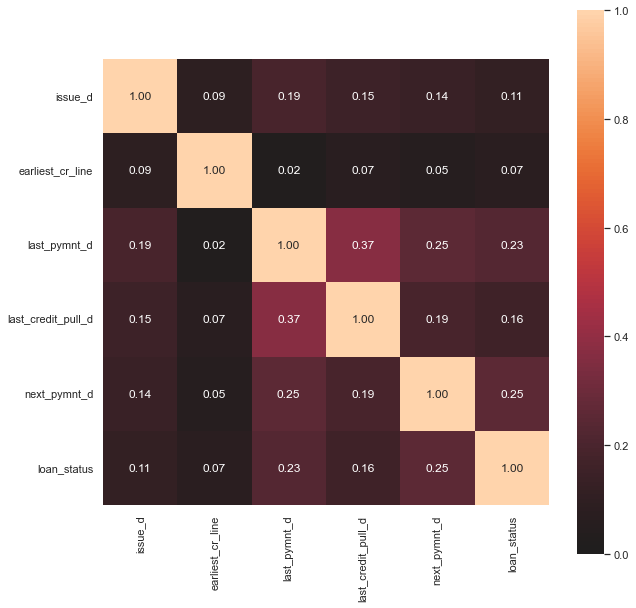

In [37]:
# Korelasi antar tanggal dan status pinjaman
used_cols = date_cols + ["loan_status"] 
complete_correlation = associations(
    pre_df[used_cols], 
    filename='date_correlation.png',
    figsize=(10,10)
)

In [38]:
# Fitur tanggal yang akan kita gunakan
affect_date_cols = ["issue_d", "last_pymnt_d", "last_credit_pull_d", "next_pymnt_d"]
affect_date_cols

['issue_d', 'last_pymnt_d', 'last_credit_pull_d', 'next_pymnt_d']

In [39]:
# Hapus fitur tanggal yang tidak memiliki korelasi kuat dengan status pinjaman
unused_cols = ["earliest_cr_line"]
pre_df = pre_df.drop(columns=unused_cols, errors="ignore")
pre_df.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,purpose,zip_code,addr_state,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
0,5000,5000,4975.0,36 months,10.65,162.87,B,B2,10+ years,RENT,24000.0,Verified,Dec-11,1,n,credit_card,860xx,AZ,27.65,0.0,1.0,NaN,NaN,3.0,0.0,13648,83.7,9.0,f,0.0,0.0,5861.071414,5831.78,5000.00,861.07,0.00,0.00,0.00,Jan-15,171.62,None,Jan-16,0.0,NaN,0.0,NaN,NaN,NaN
1,2500,2500,2500.0,60 months,15.27,59.83,C,C4,< 1 year,RENT,30000.0,Source Verified,Dec-11,0,n,car,309xx,GA,1.00,0.0,5.0,NaN,NaN,3.0,0.0,1687,9.4,4.0,f,0.0,0.0,1008.710000,1008.71,456.46,435.17,0.00,117.08,1.11,Apr-13,119.66,None,Sep-13,0.0,NaN,0.0,NaN,NaN,NaN
2,2400,2400,2400.0,36 months,15.96,84.33,C,C5,10+ years,RENT,12252.0,Not Verified,Dec-11,1,n,small_business,606xx,IL,8.72,0.0,2.0,NaN,NaN,2.0,0.0,2956,98.5,10.0,f,0.0,0.0,3003.653644,3003.65,2400.00,603.65,0.00,0.00,0.00,Jun-14,649.91,None,Jan-16,0.0,NaN,0.0,NaN,NaN,NaN
3,10000,10000,10000.0,36 months,13.49,339.31,C,C1,10+ years,RENT,49200.0,Source Verified,Dec-11,1,n,other,917xx,CA,20.00,0.0,1.0,35.0,NaN,10.0,0.0,5598,21.0,37.0,f,0.0,0.0,12226.302210,12226.30,10000.00,2209.33,16.97,0.00,0.00,Jan-15,357.48,None,Jan-15,0.0,NaN,0.0,NaN,NaN,NaN
5,5000,5000,5000.0,36 months,7.90,156.46,A,A4,3 years,RENT,36000.0,Source Verified,Dec-11,1,n,wedding,852xx,AZ,11.20,0.0,3.0,NaN,NaN,9.0,0.0,7963,28.3,12.0,f,0.0,0.0,5631.377753,5631.38,5000.00,631.38,0.00,0.00,0.00,Jan-15,161.03,None,Sep-15,0.0,NaN,0.0,NaN,NaN,NaN


### Kolom Kategorik yang Tidak Terpakai

In [40]:
other_cat_cols = cat_features[~cat_features.isin(date_cols)]
other_cat_cols

Index(['term', 'grade', 'sub_grade', 'emp_length', 'home_ownership',
       'verification_status', 'pymnt_plan', 'purpose', 'zip_code',
       'addr_state', 'initial_list_status'],
      dtype='object')

In [41]:
pre_df.loc[:, other_cat_cols].head()

,term,grade,sub_grade,emp_length,home_ownership,verification_status,pymnt_plan,purpose,zip_code,addr_state,initial_list_status
0,36 months,B,B2,10+ years,RENT,Verified,n,credit_card,860xx,AZ,f
1,60 months,C,C4,< 1 year,RENT,Source Verified,n,car,309xx,GA,f
2,36 months,C,C5,10+ years,RENT,Not Verified,n,small_business,606xx,IL,f
3,36 months,C,C1,10+ years,RENT,Source Verified,n,other,917xx,CA,f
5,36 months,A,A4,3 years,RENT,Source Verified,n,wedding,852xx,AZ,f


Beberapa kolom kategorikal yang tidak terpakai adalah:
- desc dan title karena merupakan teks.
- zip_code karena 3 angka dibelakangnya disensor
- sub_grade karena sudah memiliki kolom yang mirip yaitu grade

In [42]:
unused_cols = ["desc", "zip_code", "sub_grade", "title"]
pre_df = pre_df.drop(columns=unused_cols, errors="ignore")
pre_df.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,purpose,addr_state,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
0,5000,5000,4975.0,36 months,10.65,162.87,B,10+ years,RENT,24000.0,Verified,Dec-11,1,n,credit_card,AZ,27.65,0.0,1.0,NaN,NaN,3.0,0.0,13648,83.7,9.0,f,0.0,0.0,5861.071414,5831.78,5000.00,861.07,0.00,0.00,0.00,Jan-15,171.62,None,Jan-16,0.0,NaN,0.0,NaN,NaN,NaN
1,2500,2500,2500.0,60 months,15.27,59.83,C,< 1 year,RENT,30000.0,Source Verified,Dec-11,0,n,car,GA,1.00,0.0,5.0,NaN,NaN,3.0,0.0,1687,9.4,4.0,f,0.0,0.0,1008.710000,1008.71,456.46,435.17,0.00,117.08,1.11,Apr-13,119.66,None,Sep-13,0.0,NaN,0.0,NaN,NaN,NaN
2,2400,2400,2400.0,36 months,15.96,84.33,C,10+ years,RENT,12252.0,Not Verified,Dec-11,1,n,small_business,IL,8.72,0.0,2.0,NaN,NaN,2.0,0.0,2956,98.5,10.0,f,0.0,0.0,3003.653644,3003.65,2400.00,603.65,0.00,0.00,0.00,Jun-14,649.91,None,Jan-16,0.0,NaN,0.0,NaN,NaN,NaN
3,10000,10000,10000.0,36 months,13.49,339.31,C,10+ years,RENT,49200.0,Source Verified,Dec-11,1,n,other,CA,20.00,0.0,1.0,35.0,NaN,10.0,0.0,5598,21.0,37.0,f,0.0,0.0,12226.302210,12226.30,10000.00,2209.33,16.97,0.00,0.00,Jan-15,357.48,None,Jan-15,0.0,NaN,0.0,NaN,NaN,NaN
5,5000,5000,5000.0,36 months,7.90,156.46,A,3 years,RENT,36000.0,Source Verified,Dec-11,1,n,wedding,AZ,11.20,0.0,3.0,NaN,NaN,9.0,0.0,7963,28.3,12.0,f,0.0,0.0,5631.377753,5631.38,5000.00,631.38,0.00,0.00,0.00,Jan-15,161.03,None,Sep-15,0.0,NaN,0.0,NaN,NaN,NaN


In [43]:
other_cat_cols = cat_features[~cat_features.isin(date_cols + unused_cols)]
other_cat_cols

Index(['term', 'grade', 'emp_length', 'home_ownership', 'verification_status',
       'pymnt_plan', 'purpose', 'addr_state', 'initial_list_status'],
      dtype='object')

Terdapat korelasi yang kuat antara emp_title dengan status pinjaman, disusul dengan grade dan term. Fitur yang kurang berpengaruh lainnya tidak akan digunakan untuk prediksi.

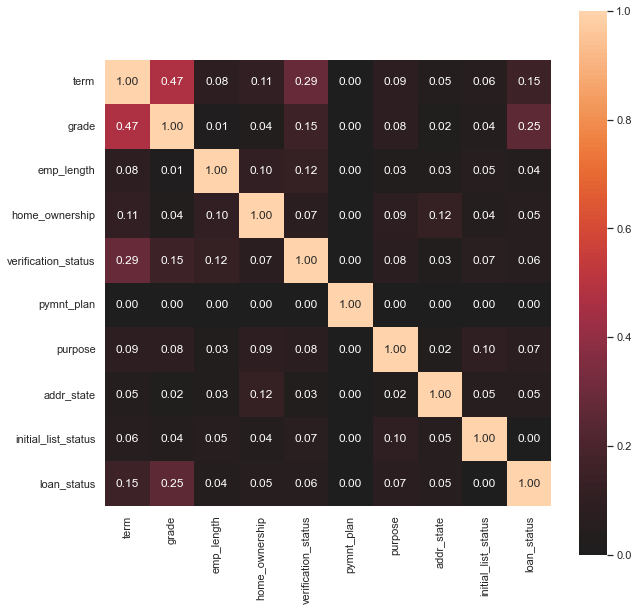

In [44]:
# Korelasi antar fitur kategorikal dan status pinjaman
used_cols = other_cat_cols.to_list() + ["loan_status"]
complete_correlation = associations(
    pre_df[used_cols], 
    filename='cat_correlation.png',
    figsize=(10,10)
)

Fitur grade dan term memiliki sedikit korelasi dengan status pinjaman.

In [45]:
# Fitur kategorikal yang akan kita gunakan
affect_cat_cols = ["grade", "term"]
affect_cat_cols

['grade', 'term']

In [46]:
# Hapus fitur yang kurang berpengaruh
used_cols = ["emp_title", "grade", "term"]
unused_cols = other_cat_cols[~other_cat_cols.isin(used_cols)]
pre_df = pre_df.drop(columns=unused_cols, errors="ignore")
pre_df.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,annual_inc,issue_d,loan_status,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
0,5000,5000,4975.0,36 months,10.65,162.87,B,24000.0,Dec-11,1,27.65,0.0,1.0,NaN,NaN,3.0,0.0,13648,83.7,9.0,0.0,0.0,5861.071414,5831.78,5000.00,861.07,0.00,0.00,0.00,Jan-15,171.62,None,Jan-16,0.0,NaN,0.0,NaN,NaN,NaN
1,2500,2500,2500.0,60 months,15.27,59.83,C,30000.0,Dec-11,0,1.00,0.0,5.0,NaN,NaN,3.0,0.0,1687,9.4,4.0,0.0,0.0,1008.710000,1008.71,456.46,435.17,0.00,117.08,1.11,Apr-13,119.66,None,Sep-13,0.0,NaN,0.0,NaN,NaN,NaN
2,2400,2400,2400.0,36 months,15.96,84.33,C,12252.0,Dec-11,1,8.72,0.0,2.0,NaN,NaN,2.0,0.0,2956,98.5,10.0,0.0,0.0,3003.653644,3003.65,2400.00,603.65,0.00,0.00,0.00,Jun-14,649.91,None,Jan-16,0.0,NaN,0.0,NaN,NaN,NaN
3,10000,10000,10000.0,36 months,13.49,339.31,C,49200.0,Dec-11,1,20.00,0.0,1.0,35.0,NaN,10.0,0.0,5598,21.0,37.0,0.0,0.0,12226.302210,12226.30,10000.00,2209.33,16.97,0.00,0.00,Jan-15,357.48,None,Jan-15,0.0,NaN,0.0,NaN,NaN,NaN
5,5000,5000,5000.0,36 months,7.90,156.46,A,36000.0,Dec-11,1,11.20,0.0,3.0,NaN,NaN,9.0,0.0,7963,28.3,12.0,0.0,0.0,5631.377753,5631.38,5000.00,631.38,0.00,0.00,0.00,Jan-15,161.03,None,Sep-15,0.0,NaN,0.0,NaN,NaN,NaN


## Fitur yang berkorelasi dengan target

In [47]:
# Kolom-kolom yang akan kita gunakan
predictor_cols = affect_num_cols + affect_cat_cols + affect_date_cols
predictor_cols

['total_rec_prncp',
 'recoveries',
 'last_pymnt_amnt',
 'collection_recovery_fee',
 'int_rate',
 'total_rec_late_fee',
 'inq_last_6mths',
 'dti',
 'grade',
 'term',
 'issue_d',
 'last_pymnt_d',
 'last_credit_pull_d',
 'next_pymnt_d']

## Imputasi Missing Value
Missing value terbanyak dimiliki oleh fitur next_pyment_d karena bisa jadi peminjam yang sudah melunasi utangnya tidak akan memiliki jadwal pembayaran lagi.

In [48]:
pre_df[predictor_cols].isna().mean().sort_values(ascending=False)

next_pymnt_d               0.984484
last_pymnt_d               0.001629
inq_last_6mths             0.000126
last_credit_pull_d         0.000100
total_rec_prncp            0.000000
recoveries                 0.000000
last_pymnt_amnt            0.000000
collection_recovery_fee    0.000000
int_rate                   0.000000
total_rec_late_fee         0.000000
dti                        0.000000
grade                      0.000000
term                       0.000000
issue_d                    0.000000
dtype: float64

In [49]:
# Isi data dengan "no"
pre_df["next_pymnt_d"] = pre_df["next_pymnt_d"].fillna("no")
top_next_pyment_d = pre_df["next_pymnt_d"].value_counts().head()
top_next_pyment_d

no        227214
Feb-16       795
Mar-11       107
Apr-11       101
Feb-11        91
Name: next_pymnt_d, dtype: int64

Lakukan hal yang sama pada kolom last_pymnt_d dan last_credit_pull_d

In [50]:
pre_df["last_pymnt_d"] = pre_df["last_pymnt_d"].fillna("no")
pre_df["last_credit_pull_d"] = pre_df["last_credit_pull_d"].fillna("no")

Isi missing value data numerik menggunakan nilai modus

In [51]:
mode = pre_df["inq_last_6mths"].mode().values[0]
pre_df["inq_last_6mths"] = pre_df["inq_last_6mths"].fillna(mode)

Cek kembali apakah masih ada data yang hilang

In [52]:
pre_df[predictor_cols].isna().mean().sort_values(ascending=False)

total_rec_prncp            0.0
recoveries                 0.0
last_pymnt_amnt            0.0
collection_recovery_fee    0.0
int_rate                   0.0
total_rec_late_fee         0.0
inq_last_6mths             0.0
dti                        0.0
grade                      0.0
term                       0.0
issue_d                    0.0
last_pymnt_d               0.0
last_credit_pull_d         0.0
next_pymnt_d               0.0
dtype: float64

# Pemodelan

## Tentukan Label dan Fitur Data
Label merupakan tingkat performa dari pinjaman yang berada pada kolom `loan_status`. Berhubung kolom tersebut memiliki beberapa kategori, kita sudah memilih dan menggabungkannya menjadi 2 kategori yaitu `baik` dan `buruk`.

Sebelumnya, kita perlu memisahkan label dan fitur dari data untuk kemudian dapat dilakukan pemisahan data.

In [53]:
label = pre_df["loan_status"].copy()
features = pre_df[predictor_cols].copy()

print("Label shape:")
print(label.shape)

print("Features shape:")
print(features.shape)

Label shape:
(230795,)
Features shape:
(230795, 14)


## Alur Pelatihan

### Praproses

In [54]:
num_features = features.select_dtypes(exclude="object")
cat_features = features.select_dtypes(include="object")

In [55]:
# Normalisasi fitur numerik
num_features = (num_features - num_features.mean()) / num_features.std()
num_features

,total_rec_prncp,recoveries,last_pymnt_amnt,collection_recovery_fee,int_rate,total_rec_late_fee,inq_last_6mths,dti
0,-0.765957,-0.222400,-0.822146,-0.149837,-0.716859,-0.139146,0.078612,1.472931
1,-1.320543,-0.071386,-0.829680,-0.140651,0.340654,-0.139146,3.480063,-2.000498
2,-1.083314,-0.222400,-0.752787,-0.149837,0.498595,-0.139146,0.928975,-0.994312
3,-0.155655,-0.222400,-0.795193,-0.149837,-0.066786,2.788316,0.078612,0.475868
5,-0.765957,-0.222400,-0.823681,-0.149837,-1.346331,-0.139146,1.779338,-0.671081
...,...,...,...,...,...,...,...,...
466276,-1.332307,1.273040,-0.815471,-0.053887,1.022774,-0.139146,-0.771750,-0.530319
466277,-0.817113,-0.222400,-0.765357,-0.149837,-1.346331,-0.139146,-0.771750,-0.784472
466278,-0.155655,-0.222400,-0.049229,-0.149837,1.022774,-0.139146,-0.771750,-0.622857
466281,-1.152029,-0.222400,-0.844495,-0.149837,1.416480,-0.139146,3.480063,0.273848


In [56]:
# OneHotEncode fitur kategorik
cat_features = pd.get_dummies(cat_features)
cat_features

,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,term_ 36 months,term_ 60 months,issue_d_Apr-08,issue_d_Apr-09,issue_d_Apr-10,issue_d_Apr-11,issue_d_Apr-12,issue_d_Apr-13,issue_d_Apr-14,issue_d_Aug-07,issue_d_Aug-08,issue_d_Aug-09,issue_d_Aug-10,issue_d_Aug-11,issue_d_Aug-12,issue_d_Aug-13,issue_d_Aug-14,issue_d_Dec-07,issue_d_Dec-08,issue_d_Dec-09,issue_d_Dec-10,issue_d_Dec-11,issue_d_Dec-12,issue_d_Dec-13,issue_d_Dec-14,issue_d_Feb-08,issue_d_Feb-09,issue_d_Feb-10,issue_d_Feb-11,issue_d_Feb-12,issue_d_Feb-13,issue_d_Feb-14,issue_d_Jan-08,issue_d_Jan-09,issue_d_Jan-10,issue_d_Jan-11,issue_d_Jan-12,issue_d_Jan-13,issue_d_Jan-14,issue_d_Jul-07,issue_d_Jul-08,issue_d_Jul-09,issue_d_Jul-10,...,next_pymnt_d_Jul-15,next_pymnt_d_Jun-08,next_pymnt_d_Jun-09,next_pymnt_d_Jun-10,next_pymnt_d_Jun-11,next_pymnt_d_Jun-12,next_pymnt_d_Jun-13,next_pymnt_d_Jun-14,next_pymnt_d_Jun-15,next_pymnt_d_Mar-08,next_pymnt_d_Mar-09,next_pymnt_d_Mar-10,next_pymnt_d_Mar-11,next_pymnt_d_Mar-12,next_pymnt_d_Mar-13,next_pymnt_d_Mar-14,next_pymnt_d_Mar-15,next_pymnt_d_May-08,next_pymnt_d_May-09,next_pymnt_d_May-10,next_pymnt_d_May-11,next_pymnt_d_May-12,next_pymnt_d_May-13,next_pymnt_d_May-14,next_pymnt_d_May-15,next_pymnt_d_Nov-08,next_pymnt_d_Nov-09,next_pymnt_d_Nov-10,next_pymnt_d_Nov-11,next_pymnt_d_Nov-12,next_pymnt_d_Nov-13,next_pymnt_d_Nov-14,next_pymnt_d_Nov-15,next_pymnt_d_Oct-08,next_pymnt_d_Oct-09,next_pymnt_d_Oct-10,next_pymnt_d_Oct-11,next_pymnt_d_Oct-12,next_pymnt_d_Oct-13,next_pymnt_d_Oct-14,next_pymnt_d_Oct-15,next_pymnt_d_Sep-08,next_pymnt_d_Sep-09,next_pymnt_d_Sep-10,next_pymnt_d_Sep-11,next_pymnt_d_Sep-12,next_pymnt_d_Sep-13,next_pymnt_d_Sep-14,next_pymnt_d_Sep-15,next_pymnt_d_no
0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
5,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
466276,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
466277,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
466278,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
466281,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [57]:
# Gabungkan Fitur
features_full = pd.concat([num_features, cat_features], axis=1)

In [58]:
features_full.shape

(230795, 411)

### Memisahkan Data

In [59]:
X_train, X_test, y_train, y_test = train_test_split(features_full, label, test_size=0.2, random_state=42, stratify=label)

In [60]:
X_train.shape, y_train.shape

((184636, 411), (184636,))

### Model

In [66]:
logres = LogisticRegression(max_iter=500, solver="sag", class_weight="balanced", n_jobs=-1)
logres

LogisticRegression(class_weight='balanced', max_iter=500, n_jobs=-1,
                   solver='sag')

In [67]:
logres.fit(X_train, y_train)

c:\Users\garci\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


LogisticRegression(class_weight='balanced', max_iter=500, n_jobs=-1,
                   solver='sag')

## Menyimpan Model

In [68]:
joblib.dump(logres, "logres.z")

['logres.z']

In [69]:
logres = joblib.load("logres.z")

# Evaluasi Model

## Baseline Model
Kita akan membuat model prediksi paling sederhana yaitu dengan memprediksi seluruh data kategori terbanyak. Hal ini dilakukan supaya kita mendapatkan patokan, berapa performa minimal yang harus dilalui oleh model machine learning kita nantinya. 

In [70]:
test_label_counts = y_test.value_counts()
test_label_counts

1    36948
0     9211
Name: loan_status, dtype: int64

In [71]:
test_label_counts.max() / test_label_counts.sum()

0.8004506163478412

## Metrik Klasifikasi

## Train

In [72]:
logres.score(X_train, y_train)

0.9673032344721506

In [73]:
report = classification_report(y_true=y_train, y_pred=logres.predict(X_train))
print(report)

              precision    recall  f1-score   support

           0       0.88      0.97      0.92     36845
           1       0.99      0.97      0.98    147791

    accuracy                           0.97    184636
   macro avg       0.94      0.97      0.95    184636
weighted avg       0.97      0.97      0.97    184636



## Test

In [74]:
logres.score(X_test, y_test)

0.9666370588617604

In [75]:
report = classification_report(y_true=y_test, y_pred=logres.predict(X_test))
print(report)

              precision    recall  f1-score   support

           0       0.88      0.97      0.92      9211
           1       0.99      0.97      0.98     36948

    accuracy                           0.97     46159
   macro avg       0.93      0.97      0.95     46159
weighted avg       0.97      0.97      0.97     46159



## Confusion Matrix

In [76]:
conf = confusion_matrix(y_true=y_test, y_pred=logres.predict(X_test))

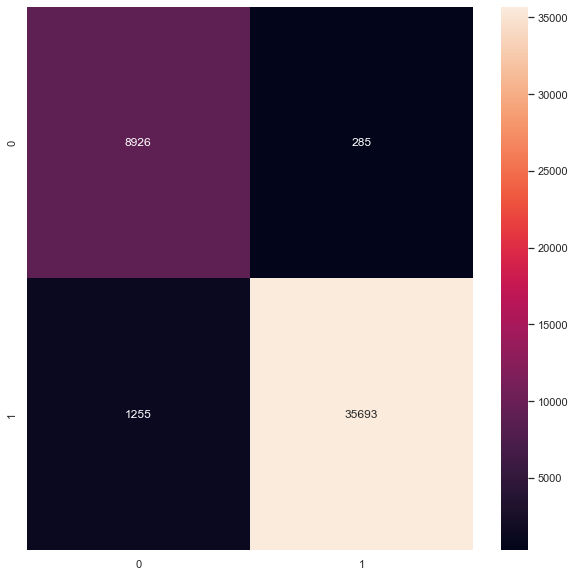

In [77]:
plt.figure(figsize=(10, 10))
sns.heatmap(conf, annot=True, fmt="g")
plt.show()